In [1]:
import openpathsampling as paths
import numpy as np
import openpathsampling.engines.msm as msm
import matplotlib.pyplot as plt
%matplotlib inline

Create a simple MSM, just 4 states, put in something bigger here

In [2]:
mat = np.array([
        [0.95,0.05,0.0,0.0],
        [0.05,0.94,0.01,0.0],
        [0.0,0.01,0.94,0.05],
        [0.0,0.0,0.05,0.95]
    ])

Create an engine first. The MSM engine takes a transition matrix. No checks are done so far.

In [3]:
engine = msm.Engine(mat)

create a first snapshot. in MSM these can also be called a `MicroState`

In [4]:
snap = msm.MicroState(
    state=0,
    engine=engine
)
engine.current_snapshot = snap

In [50]:
snap

In [60]:
r = []
ensA2AB = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB | stateA)),        
    ])
for x in range(100000):
    tt = engine.generate(snap, ensA2AB.can_append)
    r.append(stateB(tt[-1]))

In [61]:
1.0 * sum(r) / len(r)

0.00679

In [62]:
p = 1.0 * sum(r) / len(r)

In [65]:
p + np.sqrt(p * (1.0 - p) / len(r))

0.0070496901211059056

Generate a first trajectory

In [5]:
%%time
traj = engine.generate_n_frames(1000)

CPU times: user 40.6 ms, sys: 10.1 ms, total: 50.7 ms
Wall time: 44.3 ms


Define macro states, here just out of single microstates

In [6]:
stateA = msm.Block([0])
stateB = msm.Block([3])

And some interfaces (not needed for TPS)

In [7]:
intA = msm.Block([0,1])
intB = msm.Block([2,3])

Define ensembles for A->B and B->A pathways

In [42]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

And pick the first AB path

In [9]:
# first_AB_list = ensA2B.split(traj)
# firstAB = first_AB_list[0].state

as well as the first BA path

In [10]:
# first_BA_list = ensB2A.split(traj)
# firstBA = first_AB_list[0].state

Now setting up a TPS network consisting of a transition from A2B 

In [11]:
network = paths.TPSNetwork(stateA, stateB)

and a scheme

In [12]:
scheme = paths.OneWayShootingMoveScheme(
    network, 
    selector=paths.UniformSelector(), 
    engine=engine
)

generate the initial conditions, e.g. the sampleset that is used in the beginning. For TPS this is just a single sample that is in the A2B path ensemble. We will scan through all ensembles that are used and pick parts from the initial trajectory that match and add them all to a list. This list is then used to fill the initial sampleset.

In [13]:
useful_trajectory_parts = []
for ens in scheme.find_used_ensembles():
    useful_trajectory_parts.extend(ens.split(traj))

In [14]:
initial_conditions = scheme.initial_conditions_from_trajectories(useful_trajectory_parts)
print scheme.initial_conditions_report(initial_conditions)

No missing ensembles.
No extra ensembles.
No missing ensembles.
No extra ensembles.



We could save for later, but we will do this in memory.

In [15]:
# storage = paths.Storage("msm.nc", "w", use_uuid=False)
# storage.set_caching_mode('analysis')

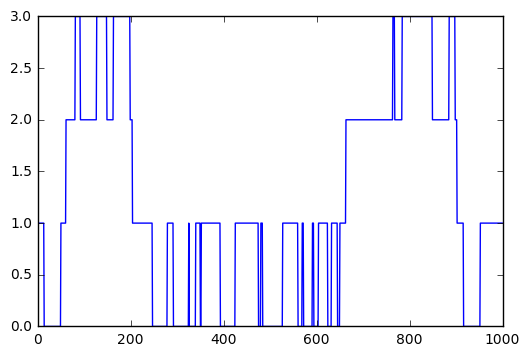

In [16]:
plt.plot(traj.state)

We use a special MSM step sampler that will add all the steps to a list instead of saving these to disk.
You could later save these using `map(storage.steps, steps)`, but we don't want to do that here.

In [17]:
steps=[]

In [18]:
sampler = msm.StepSampling(
    steplist=steps,  
    move_scheme=scheme,
    sample_set=initial_conditions
)

In [19]:
%%time
sampler.run(5000)

Working on Monte Carlo cycle number 5000
Running for 90 seconds - 55.35 steps per second
Expected time to finish: 0 seconds
DONE! Completed 5000 Monte Carlo cycles.
CPU times: user 1min 21s, sys: 27 s, total: 1min 48s
Wall time: 1min 30s


In [20]:
len(steps)

5001

In [20]:
# sum(map(len, storage.trajectories))

In [21]:
# len(storage.trajectories)

In case we want to analyze from storage

In [22]:
# steps = storage.steps

In [21]:
steps[0].active

Get the path lengths

In [22]:
path_lengths = [len(step.active[0].trajectory) for step in steps[1:]]

Maximum: 179 (1790)
Average: 37.71 (377.08)


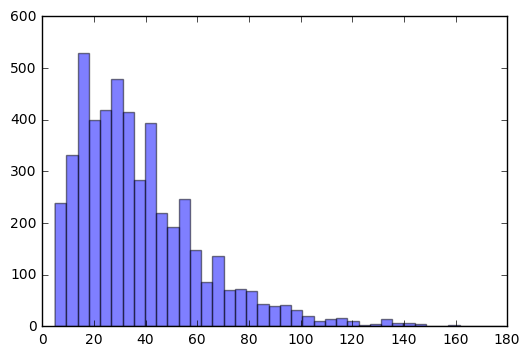

In [23]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);


In [24]:
ooms = np.array([np.dot(np.diag([1 if x == row else 0 for x in range(4)]), mat) for row in range(len(mat))])

Use OOM formalism to compute path probability

In [26]:
oA = ooms[0]
oX = ooms[1] + ooms[2]
oB = ooms[3]
ones = np.ones(4)
pin = np.linalg.eig(mat)[1][0]
pi = pin / sum(pin)

In [27]:
v1 = np.dot(np.dot(pi, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(np.eye(4) - oX))), oB)), ones)
v2 = np.dot(np.dot(pi, oA), ones)

In [32]:
v1/v2

0.0071428571428571305

**TODO: Use analytic expression for pathlength**

And some visualization

In [29]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

In [30]:
history = ops_vis.PathTree(
    steps[:250],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
history.states = {
    'red': stateA,
    'orange': msm.Block([1]),
    'greenyellow': msm.Block([2]),
    'green': stateB
}
history.options.css['scale_x'] = 3
history.options.css['scale_y'] = 5
history.options.movers['ForwardShootMover']['suffix'] = ''
history.options.movers['BackwardShootMover']['suffix'] = ''
history.options.ui['legends'] = []
history.options.css['width'] = '100%'

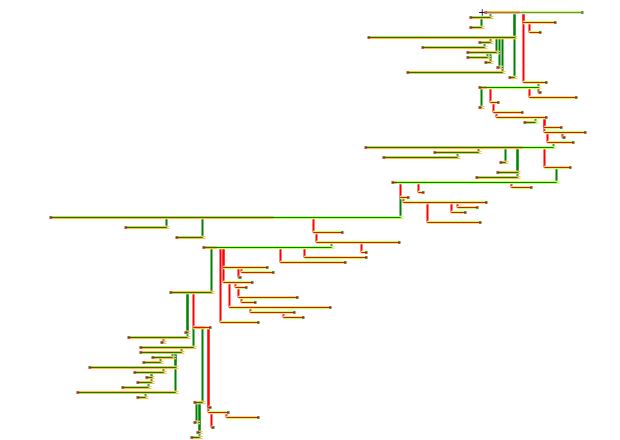

In [31]:
SVG(history.svg())